In [98]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic
import scipy.integrate as integrate

Setup: <br>
Unobservable $\mu_i \sim \pi(\cdot)$ <br>
Observable $X_i \sim N(\mu_i, \sigma^2)$ for some $\sigma^2$

In [438]:
means = np.random.normal(0, 1, 10000)**2 - 3  # Suppose mu has shifted chi-squared distribution
values = np.random.normal(means, 2, 10000)

$\eta = X^T\beta$ <br>
Model $f(X) = e^{X^T\beta}$ <br>
$e^{\theta} = \lambda = Nd \cdot f(X)$ <br>
$\Rightarrow$ Link function $g(\mu)=log(\frac{\mu}{Nd})$ <br>

In [439]:
def GetIntegral(beta, low, high):
    area = integrate.quad(lambda x: np.exp((x**np.arange(len(beta))) @ beta), low, high)
    if area[1]/area[0] > 1e-4:
        print("Integral did not converge")
        return None
    elif area[1] < 0 :
        print("Negative result")
        return None
    return area[0]

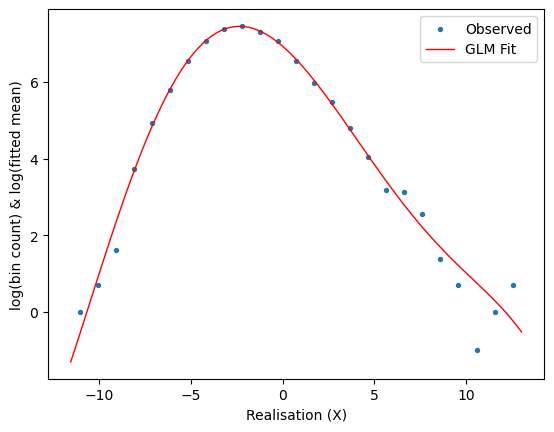

In [501]:
def LindseysMethod(data, bins, degree, random_init=50, max_iter=20, tol=1e-6):  # Poisson Regression
    result = binned_statistic(data, data, bins=bins, statistic='count')
    x = (result.bin_edges[:-1] + result.bin_edges[1:])/2
    scaling = len(data)*(result.bin_edges[1]-result.bin_edges[0])
    Y = result.statistic.astype(int)
    Y_copy = Y.copy().astype(np.float32)
    Y_copy[Y_copy == 0] = 0.5
    log_y = np.where(Y_copy > 0.5, np.log(Y_copy), -1)
    plt.scatter(x, log_y, s=8, label="Observed")
    X = x[:, None]**np.arange(0, degree+1)

    xs = np.linspace(result.bin_edges[0], result.bin_edges[-1], 100)
    Xs = xs[:, None]**np.arange(0, degree+1)
    log_cumsum = np.concatenate(([0], np.log(np.arange(1, Y.max()+1)).cumsum()))

    coef_range = 1/(10**np.arange(1, degree+2))
    betas = []
    LLs = []
    for i in range(random_init):
        initial_beta = np.random.rand(degree+1)*coef_range-coef_range/2  # Random beta initialisation
        beta = initial_beta.copy()
        
        eta = X @ beta
        mu = np.exp(eta)*scaling
        theta = np.log(mu)
        prev_LL = np.sum(Y*theta-mu) - np.sum(log_cumsum[Y])
        for i in range(max_iter):  # Iteratively Reweighted Least Squares
            eta = X @ beta
            mu = np.exp(eta)*scaling
            R = (Y - mu)/mu
            W = np.diag(mu)
            
            update = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ R
            beta += update  # Update beta with IRLS rule
    
            eta = X @ beta
            mu = np.exp(eta)*scaling
            theta = np.log(mu)
            LL = np.sum(Y*theta-mu) - np.sum(log_cumsum[Y])  # Calculate new log-likelihood (monotonic since Hessian = -X^T W X is negative definite)
            if LL < prev_LL or np.abs((LL-prev_LL)/prev_LL) < tol:
                break
            else:
                prev_LL = LL
        # Re-normalise such that f=e^{X^T \beta} is a density
        beta[0] += -np.log(GetIntegral(beta, values.min(), values.max()))
        betas.append(beta)
        LLs.append(LL)

    beta = betas[np.argmax(LLs)]
    fit = np.exp(Xs @ beta)*scaling
    plt.plot(xs, np.log(fit), c='r', linewidth=1, label="GLM Fit")
    plt.xlabel("Realisation (X)")
    plt.ylabel("log(bin count) & log(fitted mean)")
    plt.legend()
        
    return beta, np.max(LLs)

np.random.seed(0)
beta, LL = LindseysMethod(values, 25, 5)

### Tweedie's Formula
$\mathbb{E}[\mu \vert X] = X + \sigma^2 (log f(X))'$

In [502]:
def dlog_f(Xs, beta):
    matrix = Xs[:, None]**np.arange(0, len(beta)-1) * np.arange(1, len(beta))
    return matrix @ beta[1:]

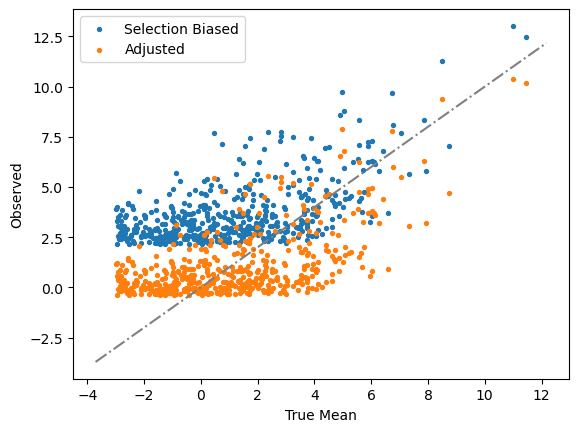

In [503]:
order = np.argsort(values)
points = 500
plt.scatter(means[order[-points:]], values[order[-points:]], s=8, label="Selection Biased")
plt.scatter(means[order[-points:]], values[order[-points:]] + 4*dlog_f(values[order[-points:]], beta), s=8, label="Adjusted")
plt.plot(plt.gca().get_xlim(), plt.gca().get_xlim(), c='grey', linestyle='-.')
plt.xlabel("True Mean")
plt.ylabel("Observed")
plt.legend();

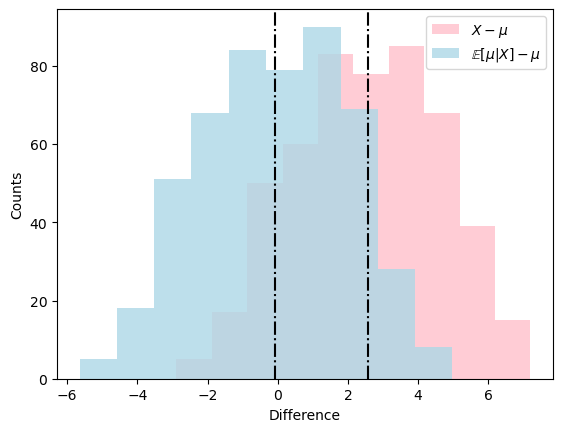

In [543]:
var = 4
plt.hist(values[order[-points:]] - means[order[-points:]], alpha=0.8, label=r"$X-\mu$", color='pink')
plt.axvline(x=(values[order[-points:]] - means[order[-points:]]).mean(), color='k', linestyle='-.')
plt.hist(values[order[-points:]] + var*dlog_f(values[order[-points:]], beta) - means[order[-points:]], alpha=0.8, 
         label=r"$\mathbb{E}[\mu \vert X]-\mu$", color='lightblue')
plt.axvline(x=(values[order[-points:]] + var*dlog_f(values[order[-points:]], beta) - means[order[-points:]]).mean(), color='k', linestyle='-.')
plt.ylabel("Counts")
plt.xlabel("Difference")
plt.legend();

### How to estimate $\sigma$ in practice if it is unknown?
If we can estimate $\mu_i\approx \mathbb{E}[\mu \vert X_i]$ accurately, $X_i-\mathbb{E}[\mu \vert X_i]$ should have empirical standard error close to $\sigma$.  <br>
Try different values of $\sigma$ and compute $\mathbb{E}[\mu \vert X_i]$. The resulting std($X_i-\mathbb{E}[\mu \vert X_i]$) should be consistent with the guess $\sigma$.

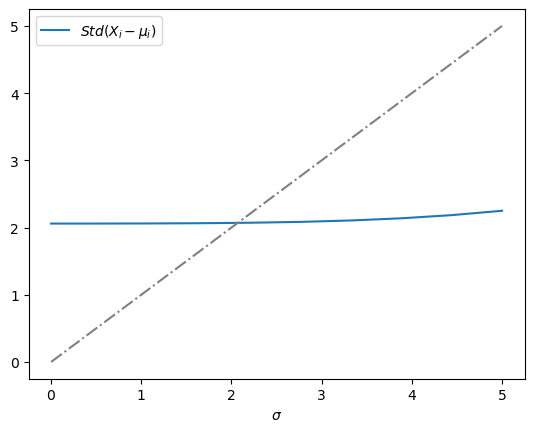

In [553]:
stds = np.linspace(0.001, 5, 10)
plt.plot(stds, [(values[order[-points:]] + (std**2)*dlog_f(values[order[-points:]], beta) - means[order[-points:]]).std() for std in stds],
        label=r"$Std(X_i-\mu_i)$")
plt.plot([stds[0], stds[-1]], [stds[0], stds[-1]], c='grey', linestyle='-.')
plt.xlabel(r"$\sigma$")
plt.legend();